## Notebook to push the identified donor IDs from demultiplexing back into the data for the Cellranger-atac aggr ATAC data

In [1]:
!date

Wed Aug 30 14:43:08 EDT 2023


#### import libraries and set notebook variables

In [2]:
from pandas import read_csv, concat
from numpy import where
from scvi.data import read_10x_atac
import scipy
from anndata import AnnData
from seaborn import barplot
import matplotlib.pyplot as plt
from matplotlib.pyplot import rc_context

# for white background of figures (only for docs rendering)
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
%config InlineBackend.figure_format='retina'

/home/gibbsr/anaconda3/lib/python3.9/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/home/gibbsr/anaconda3/lib/python3.9/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (


In [3]:
# naming
project = 'aging_phase2'
modality = 'ATAC'
set_name = f'{project}_{modality}'

# directories
wrk_dir = '/labshare/raph/datasets/adrd_neuro/brain_aging/phase2'
info_dir = f'{wrk_dir}/sample_info'
quants_dir = f'{wrk_dir}/quants'
demux_dir = f'{wrk_dir}/demux'
src_dir = f'{wrk_dir}/src_data'

# in files
atac_10x_mtx = f'{src_dir}/{modality.lower()}/{project}_consensus_aggr/outs/filtered_peak_bc_matrix'
# important to have samples in same order as aggr so read input file to get
aggr_setup_file = f'{src_dir}/{modality.lower()}/{project}_consensus_aggr/outs/aggregation_csv.csv'
info_file = f'{info_dir}/{project}.sample_info.csv'

# out files
output_file = f'{quants_dir}/{set_name}.raw.h5ad'

# constants
DEBUG = False

#### visualization functions

In [4]:
# function to plot the barcode counts by sample
def plot_sample_barcode_counts(this_df, sample_name, id_col='sample_id'):
    with rc_context({'figure.figsize': (12, 12), 'figure.dpi': 100}):
        plt.style.use('seaborn-talk')    
        barplot(x=this_df[id_col].value_counts().index, 
                y=this_df[id_col].value_counts().values, 
                order=this_df[id_col].value_counts().index,
                palette='Blues_d')
        plt.xticks(rotation=90, fontsize=8)
        plt.tight_layout()
        plt.title(sample_name)
        plt.ylabel('barcode counts')
        plt.show()
    print(this_df[id_col].value_counts())

#### utility functions

In [5]:
def parse_pool_name(name: str):
    parts = name.split('_')
    pool_num = parts[1].replace('P', '')
    lane_num = parts[2]    
    assay = parts[0]
    return pool_num, lane_num, assay

### load the sample info data

In [6]:
info_df = read_csv(info_file)
print(f'shape of info {info_df.shape}')
if DEBUG:
    display(info_df.head())
    display(info_df.gex_pool.value_counts())
    display(info_df.atac_pool.value_counts())    

shape of info (36, 13)


#### read the 10X Cellranger-atac aggr input sample sheet

In [7]:
tenx_aggr_in = read_csv(aggr_setup_file)
print(tenx_aggr_in.shape)
cell_pools = tenx_aggr_in['library_id'].to_list()
if DEBUG:
    display(tenx_aggr_in.head())
print(cell_pools)

(32, 3)
['ATAC_P1_1', 'ATAC_P1_2', 'ATAC_P1_3', 'ATAC_P1_4', 'ATAC_P1_5', 'ATAC_P1_6', 'ATAC_P2_1', 'ATAC_P2_2', 'ATAC_P2_3', 'ATAC_P2_4', 'ATAC_P2_5', 'ATAC_P2_6', 'ATAC_P3_1', 'ATAC_P3_2', 'ATAC_P3_3', 'ATAC_P3_4', 'ATAC_P3_5', 'ATAC_P3_6', 'ATAC_P3_7', 'ATAC_P3_8', 'ATAC_P6_1', 'ATAC_P6_2', 'ATAC_P6_3', 'ATAC_P6_4', 'ATAC_P6_5', 'ATAC_P6_6', 'ATAC_P6_7', 'ATAC_P6_8', 'ATAC_P7_1', 'ATAC_P7_2', 'ATAC_P7_3', 'ATAC_P7_4']


#### load the 10X matrix files

In [8]:
%%time
adata = read_10x_atac(atac_10x_mtx)
# read the count matrix into a sparse matrix, and the cell and region annotations as pandas DataFrames
# counts = scipy.io.mmread(f'{atac_10x_mtx}/matrix.mtx').T
# regions = read_csv(f'{atac_10x_mtx}/peaks.bed', sep='\t', header=None, 
#                    names=['chr', 'start', 'end'],)
# cells = read_csv(f'{atac_10x_mtx}/barcodes.tsv', header=None, 
#                  names=['barcodes'], index_col=0)
# # then initialize a new AnnData object
# adata = AnnData(X=counts, obs=cells, var=regions)

CPU times: user 21min 1s, sys: 9.91 s, total: 21min 11s
Wall time: 21min 9s


/home/gibbsr/anaconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [9]:
print(adata)
if DEBUG:
    display(adata.obs.head())

AnnData object with n_obs × n_vars = 119601 × 221430
    obs: 'batch_id'
    var: 'chr', 'start', 'end'


In [10]:
bdata = adata.copy()

#### load the demuxlet results

In [11]:
results_df = None
for index, pool_name in enumerate(cell_pools, 1):
    pool_num, lane_name, _ = parse_pool_name(pool_name)
    best_file = f'{demux_dir}/{pool_name}.best'
    demux_df = read_csv(best_file, sep='\s+')
    # set another best sample column and if doublet or ambigous set that as ID
    demux_df['sample_id'] = where(demux_df['DROPLET.TYPE'] == 'SNG', 
                                demux_df['SNG.BEST.GUESS'], 
                                where(demux_df['DROPLET.TYPE'] == 'DBL', 
                                      'doublet', 'ambiguous'))
    demux_df['BARCODE'] = demux_df['BARCODE'].str.replace('-1', f'-{index}')
    demux_df['pool_name'] = pool_name
    demux_df['pool_num'] = pool_num
    demux_df['lane_num'] = lane_name
    results_df = concat([results_df, demux_df])
    
print(f'shape of results {results_df.shape}')    
if DEBUG:
    display(results_df.sample(5))

shape of results (119491, 24)


In [12]:
display(results_df.sample_id.value_counts())
display(results_df['DROPLET.TYPE'].value_counts())

sample_id
doublet      15863
Aging138      6245
Aging127      5552
Aging130      5268
Aging129      5025
Aging100      4610
Aging140      3944
Aging089      3859
Aging132      3833
Aging139      3802
Aging092      3675
ambiguous     3651
Aging128      3648
Aging070      3591
Aging122      3495
Aging141      3337
Aging137      3164
Aging131      3135
Aging085      2977
Aging126      2938
Aging135      2771
Aging104      2692
Aging134      2658
Aging123      2497
Aging096      2491
Aging124      2149
Aging112      2058
Aging116      2056
Aging136      1908
Aging125      1893
Aging077      1883
Aging133      1562
Aging108       908
Aging081       350
Aging142         3
Name: count, dtype: int64

DROPLET.TYPE
SNG    99977
DBL    15863
AMB     3651
Name: count, dtype: int64

In [13]:
display(results_df.groupby('pool_num').sample_id.value_counts())

pool_num  sample_id
1         Aging070     3591
          Aging104     2692
          doublet      2677
          Aging096     2491
          Aging112     2058
          Aging108      908
          Aging081      350
          ambiguous     159
2         Aging100     4610
          Aging089     3859
          Aging092     3675
          Aging085     2977
          Aging116     2056
          doublet      1905
          Aging077     1883
          ambiguous     310
3         Aging127     5552
          Aging129     5025
          doublet      4196
          Aging128     3648
          Aging122     3495
          Aging126     2938
          Aging123     2497
          ambiguous    2494
          Aging124     2149
          Aging125     1893
6         Aging138     6245
          Aging130     5268
          doublet      4731
          Aging132     3833
          Aging139     3802
          Aging131     3135
          Aging135     2771
          Aging134     2658
          Aging133     1562


#### merge sample info with demuxlet info

In [14]:
print(results_df.shape)
# display(obs_id_df.head())
results_df = results_df.merge(info_df, how='left', 
                              left_on='sample_id', right_on='sample_id')
print(f'combined info shape {results_df.shape}')
if DEBUG:
    display(results_df.head())
    print(results_df['sample_id'].value_counts())
    print(results_df['hbcc_id'].value_counts())
    print(results_df['sex'].value_counts())
    print(results_df['ancestry'].value_counts())
    print(results_df['age'].describe())    
    print(results_df['gex_pool'].value_counts())
    print(results_df['atac_pool'].value_counts())    
    print(results_df['smoker'].value_counts())
    print(results_df['pmi'].describe())
    print(results_df['ph'].describe())
    print(results_df['bmi'].describe())
    print(results_df['rin'].describe()) 

(119491, 24)
combined info shape (119491, 36)


#### if ATAC combine the anndata obs barcode and batch_ids into unique ID like 10X outputs but scvi splits

In [15]:
adata.obs['BARCODE'] = adata.obs.index
adata.obs['BARCODE'] = adata.obs['BARCODE'] + '-' + adata.obs['batch_id'].astype('string')
adata.obs['BARCODE'] = adata.obs['BARCODE'].tolist()
adata.obs.set_index('BARCODE', inplace=True)

In [16]:
if DEBUG:
    display(adata.obs.head())

#### there may be a small descrepancy between the per pool barcodes demultiplexed and the across pool aggregation barcodes, assuming small variation in filtering maybe

- make the barode set consistent

In [17]:
found_barcodes = set(adata.obs.index) & set(results_df['BARCODE'])
print(f'lenght of found barcodes is {len(found_barcodes)}')
lost_count = adata.obs.shape[0] - len(found_barcodes)
print(f'will loose {lost_count} barcodes')
if lost_count < 10:
    set(adata.obs.index) - set(results_df['BARCODE'])

# trim any missing barcodes
if lost_count > 0:
    adata = adata[adata.obs.index.isin(found_barcodes)]
    results_df = results_df.loc[results_df.BARCODE.isin(found_barcodes)]
    print(adata)
    print(f'corrected shape of demultiplexing results {results_df.shape}')

lenght of found barcodes is 119491
will loose 110 barcodes
View of AnnData object with n_obs × n_vars = 119491 × 221430
    obs: 'batch_id'
    var: 'chr', 'start', 'end'
corrected shape of demultiplexing results (119491, 36)


#### index the demultiplexed IDs with the anndata obs barcodes

In [18]:
cols_to_keep = ['sample_id', 'BARCODE', 'geno_IID', 'sex', 'ancestry', 'age', 
                'gex_pool', 'atac_pool', 'pmi', 'ph', 'smoker', 'bmi', 'rin', 
                'hbcc_id']
obs_id_df = results_df[cols_to_keep].copy()
obs_id_df = obs_id_df.set_index('BARCODE')
obs_id_df = obs_id_df.reindex(adata.obs.index)
# fill any missing barcode IDs
obs_id_df['sample_id'] = obs_id_df['sample_id'].fillna('unknown')
obs_id_df['donor_id'] = obs_id_df['hbcc_id']
obs_id_df = obs_id_df.drop(columns=['hbcc_id'])
print(f'shape of demux info to add to obs {obs_id_df.shape}')
if DEBUG:
    display(obs_id_df.sample(5))

shape of demux info to add to obs (119491, 13)


#### add the new obs info table into the anndata obs

In [19]:
print(adata.obs.index.equals(obs_id_df.index))
adata.obs = concat([adata.obs, obs_id_df], axis='columns')
print(adata)
if DEBUG:
    display(adata.obs.head())

True
AnnData object with n_obs × n_vars = 119491 × 221430
    obs: 'batch_id', 'sample_id', 'geno_IID', 'sex', 'ancestry', 'age', 'gex_pool', 'atac_pool', 'pmi', 'ph', 'smoker', 'bmi', 'rin', 'donor_id'
    var: 'chr', 'start', 'end'


#### indices should be the same, confirm

In [20]:
print(obs_id_df.index.equals(adata.obs.index))

True


In [21]:
display(adata.obs['sample_id'].value_counts())

sample_id
doublet      15863
Aging138      6245
Aging127      5552
Aging130      5268
Aging129      5025
Aging100      4610
Aging140      3944
Aging089      3859
Aging132      3833
Aging139      3802
Aging092      3675
ambiguous     3651
Aging128      3648
Aging070      3591
Aging122      3495
Aging141      3337
Aging137      3164
Aging131      3135
Aging085      2977
Aging126      2938
Aging135      2771
Aging104      2692
Aging134      2658
Aging123      2497
Aging096      2491
Aging124      2149
Aging112      2058
Aging116      2056
Aging136      1908
Aging125      1893
Aging077      1883
Aging133      1562
Aging108       908
Aging081       350
Aging142         3
Name: count, dtype: int64

#### check that we aren't missing any barcodes

In [22]:
len(set(adata.obs.index) - set(results_df['BARCODE']))
# set(adata.obs.index) - set(results_df['BARCODE'])

0

In [23]:
obs_id_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 119491 entries, AAACGAAAGAAACGCC-29 to TTTGTGTTCTTGTCGC-18
Data columns (total 13 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   sample_id  119491 non-null  object 
 1   geno_IID   99977 non-null   object 
 2   sex        99977 non-null   object 
 3   ancestry   99977 non-null   object 
 4   age        99977 non-null   float64
 5   gex_pool   99977 non-null   float64
 6   atac_pool  99977 non-null   float64
 7   pmi        99977 non-null   float64
 8   ph         99977 non-null   float64
 9   smoker     94952 non-null   float64
 10  bmi        94952 non-null   float64
 11  rin        68827 non-null   float64
 12  donor_id   99977 non-null   object 
dtypes: float64(8), object(5)
memory usage: 16.8+ MB


### visualize the counts by sample

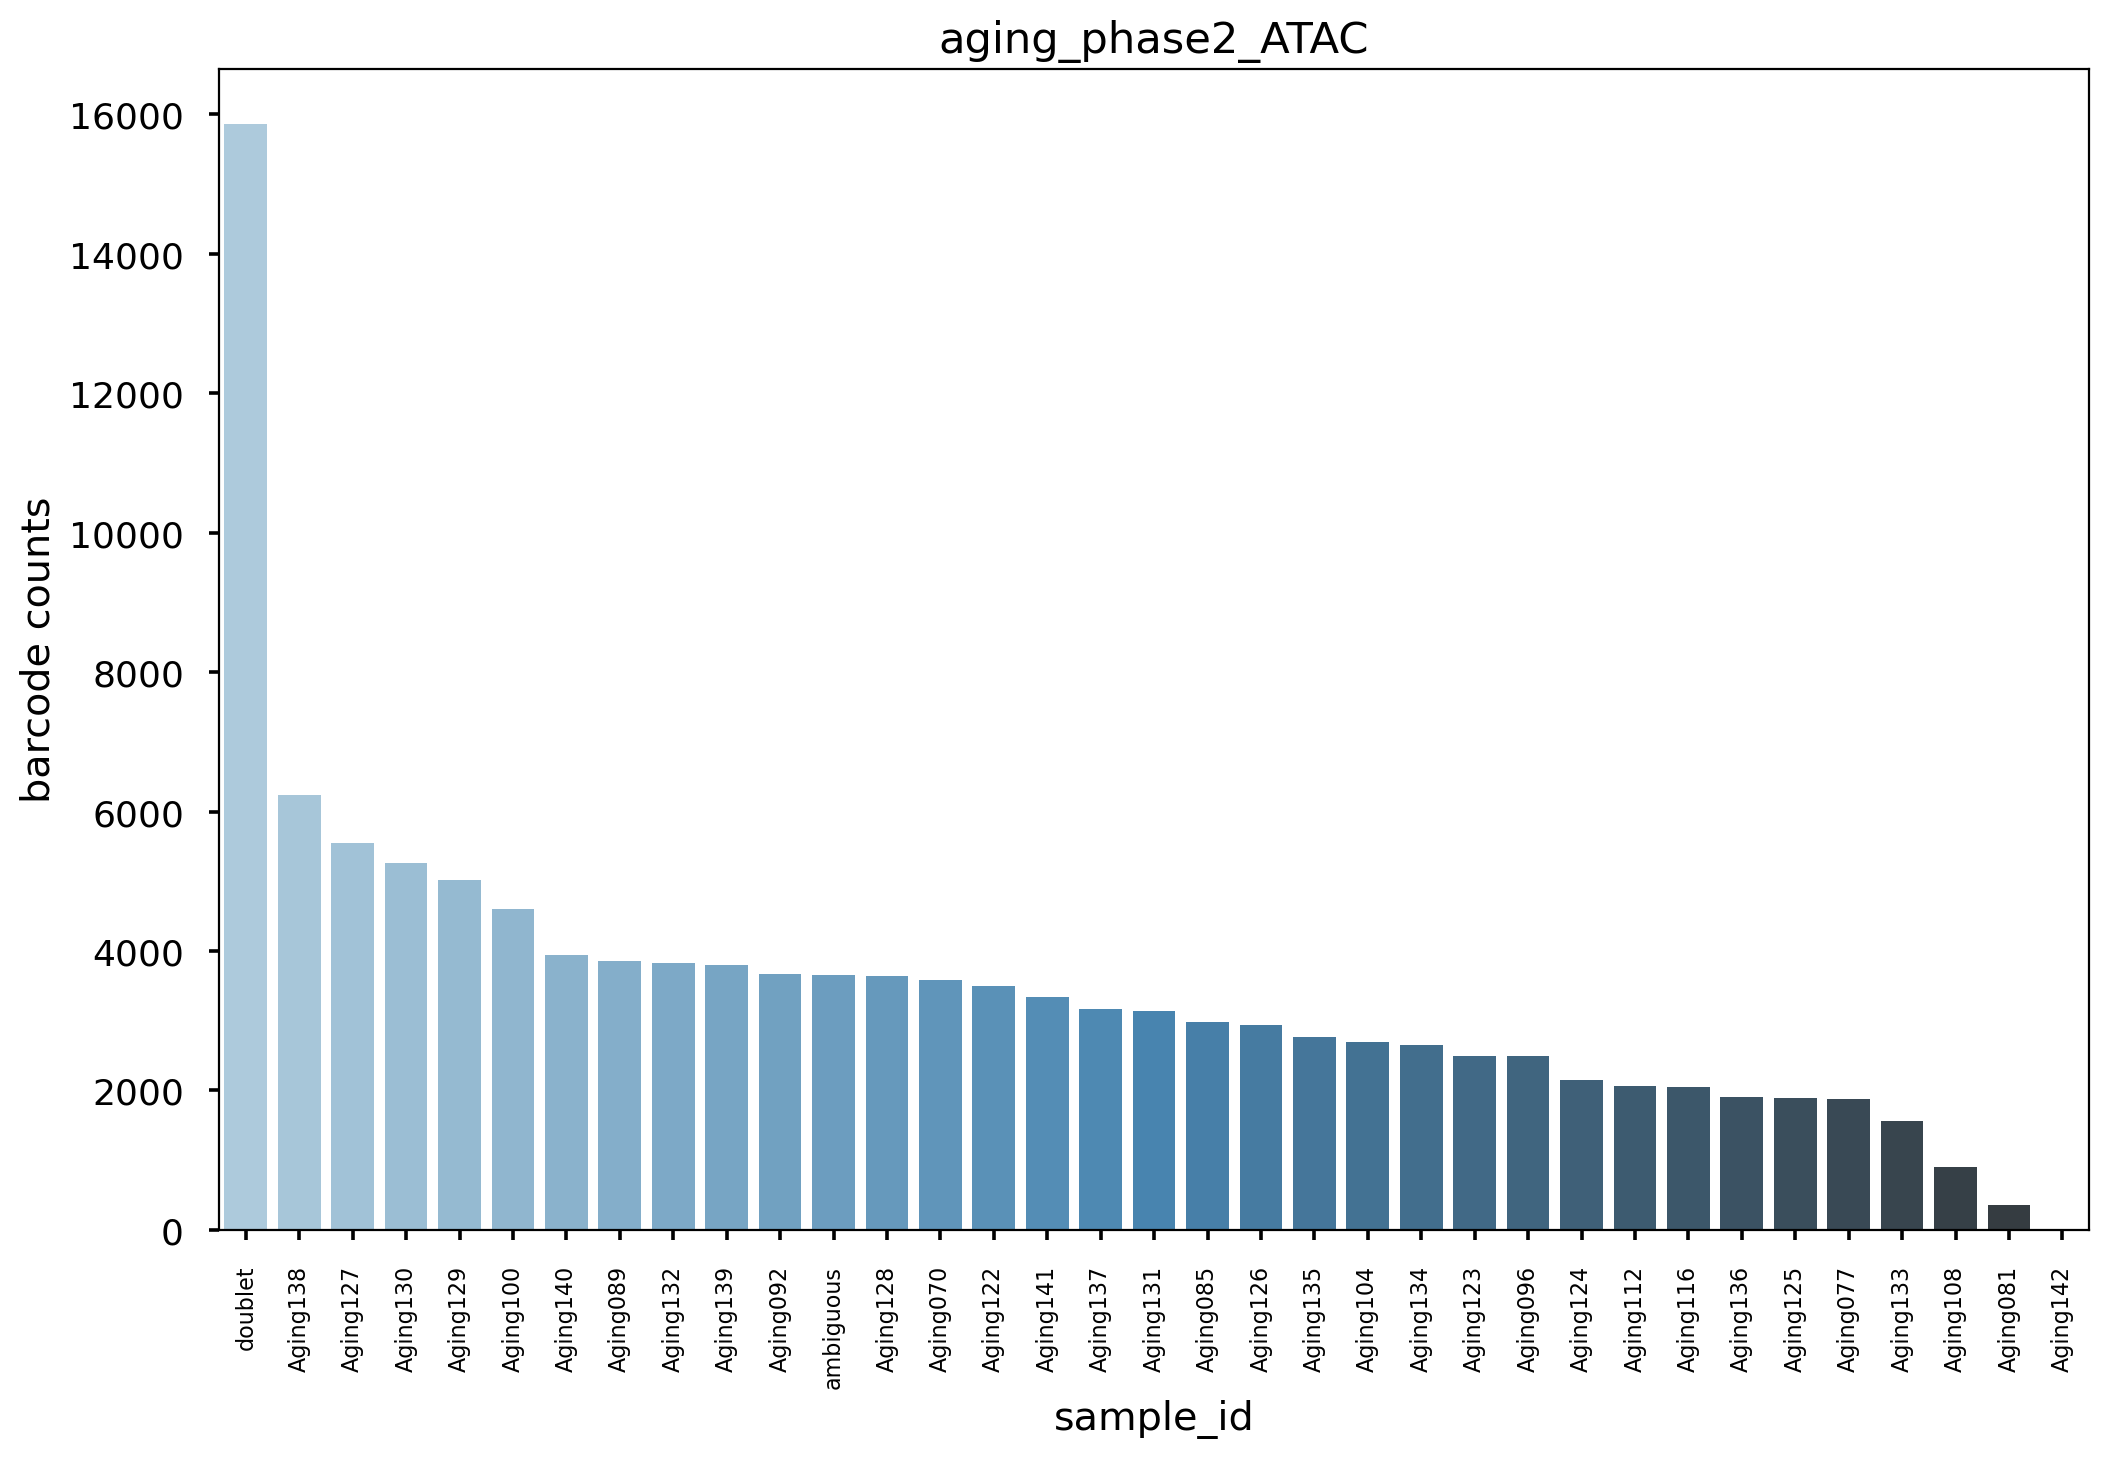

sample_id
doublet      15863
Aging138      6245
Aging127      5552
Aging130      5268
Aging129      5025
Aging100      4610
Aging140      3944
Aging089      3859
Aging132      3833
Aging139      3802
Aging092      3675
ambiguous     3651
Aging128      3648
Aging070      3591
Aging122      3495
Aging141      3337
Aging137      3164
Aging131      3135
Aging085      2977
Aging126      2938
Aging135      2771
Aging104      2692
Aging134      2658
Aging123      2497
Aging096      2491
Aging124      2149
Aging112      2058
Aging116      2056
Aging136      1908
Aging125      1893
Aging077      1883
Aging133      1562
Aging108       908
Aging081       350
Aging142         3
Name: count, dtype: int64


In [24]:
plot_sample_barcode_counts(adata.obs, set_name)

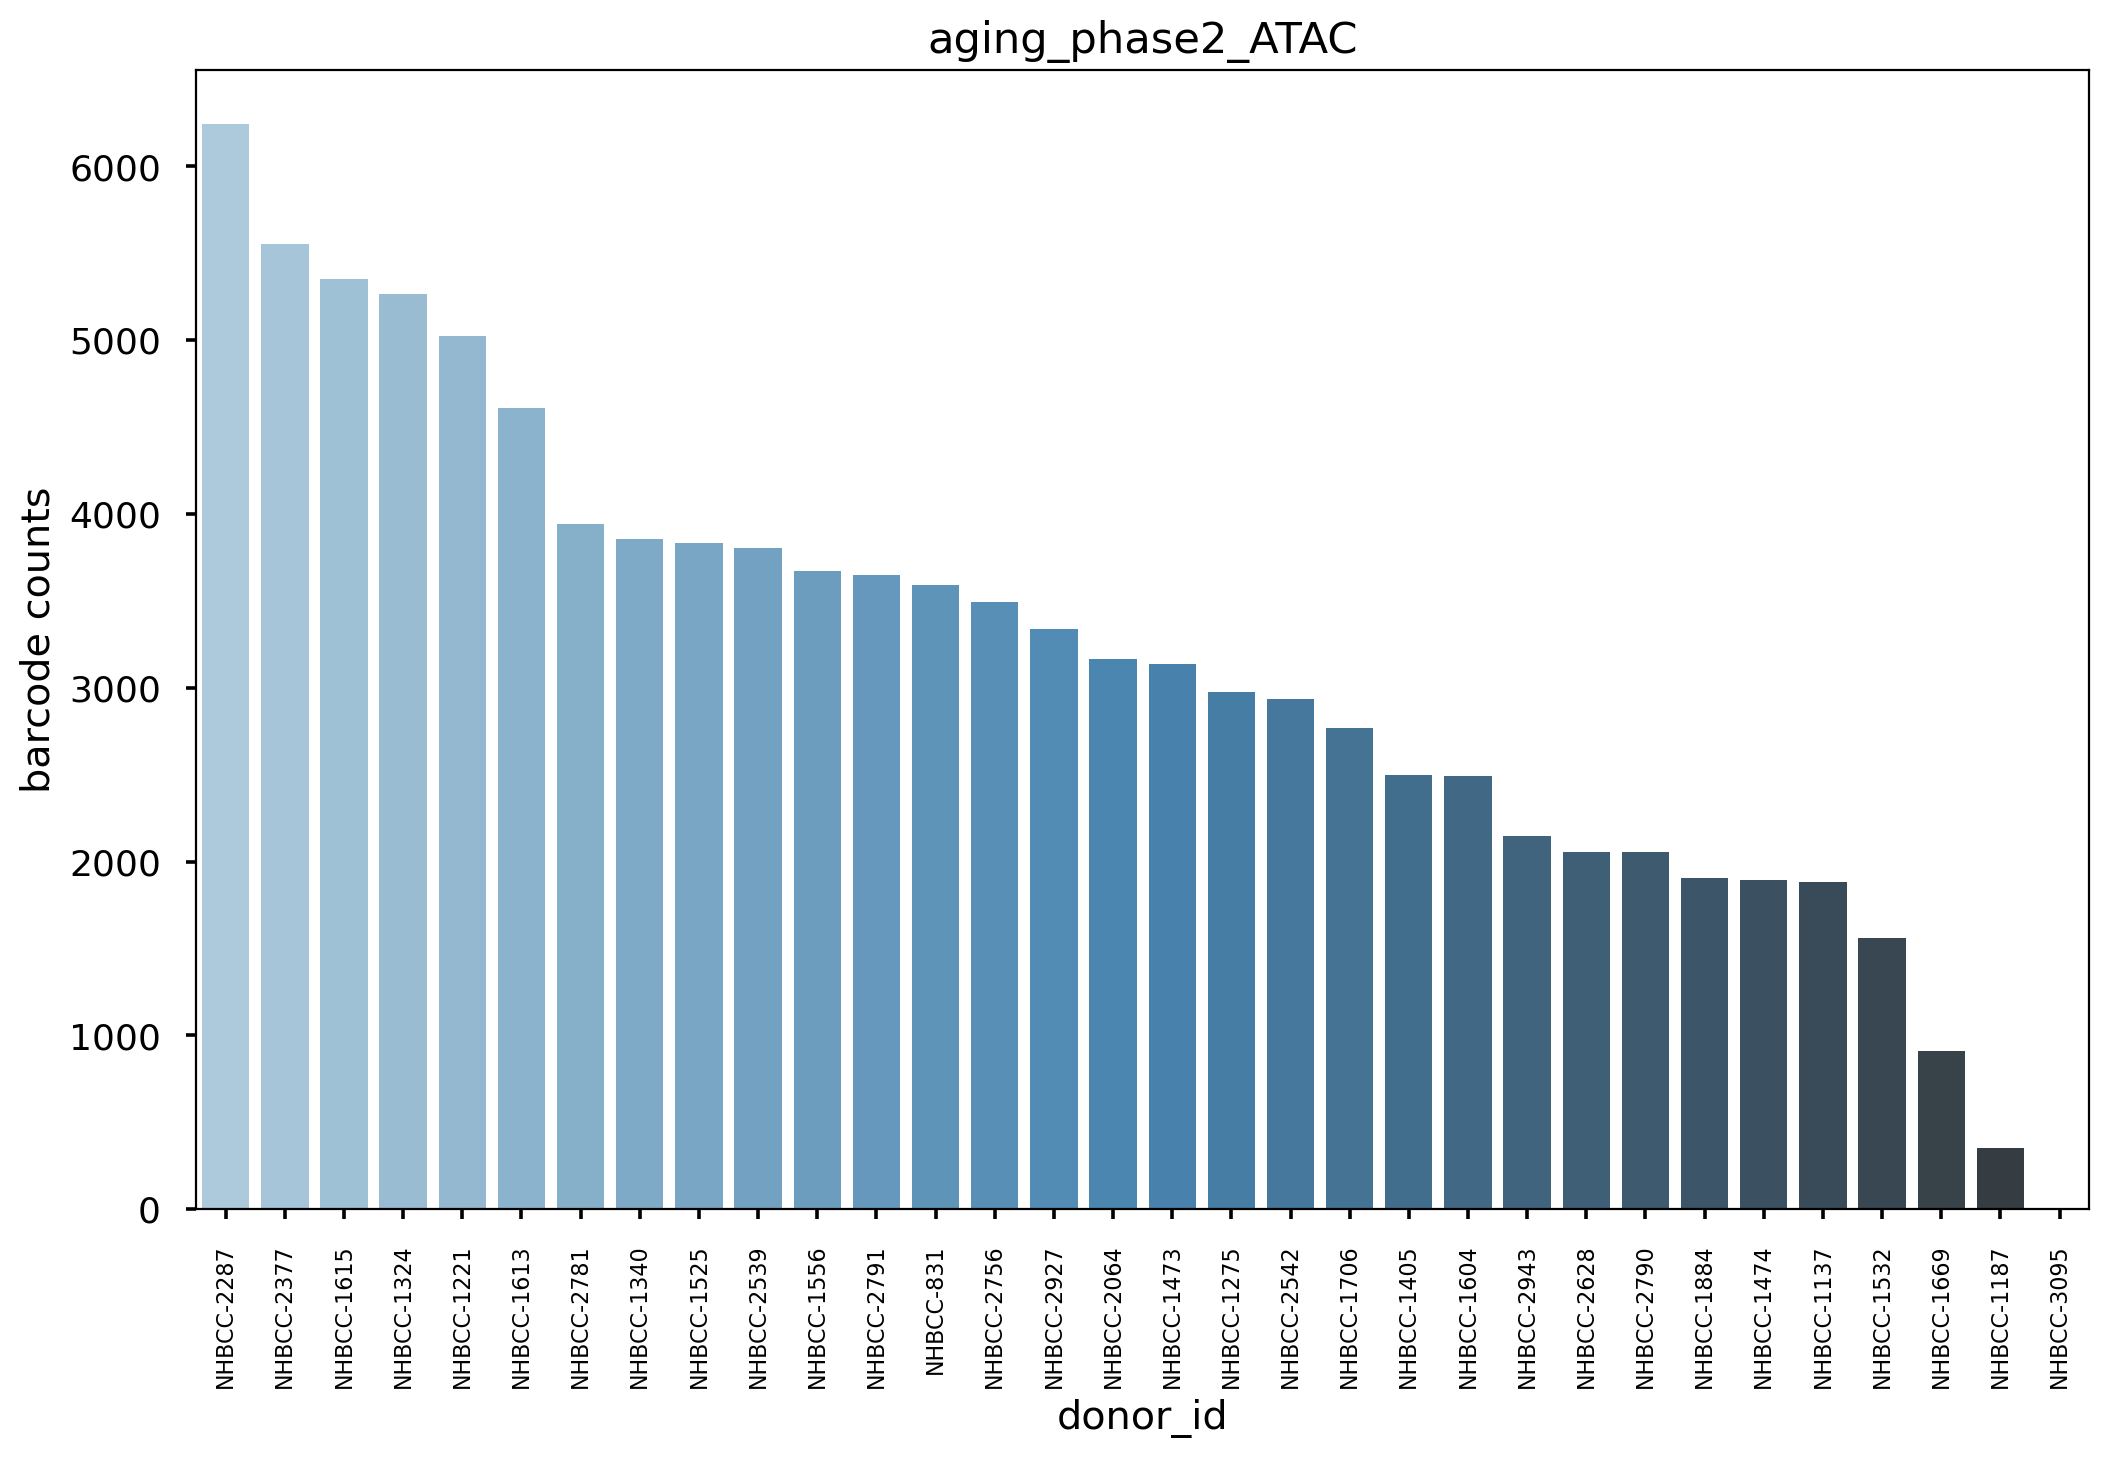

donor_id
NHBCC-2287    6245
NHBCC-2377    5552
NHBCC-1615    5350
NHBCC-1324    5268
NHBCC-1221    5025
NHBCC-1613    4610
NHBCC-2781    3944
NHBCC-1340    3859
NHBCC-1525    3833
NHBCC-2539    3802
NHBCC-1556    3675
NHBCC-2791    3648
NHBCC-831     3591
NHBCC-2756    3495
NHBCC-2927    3337
NHBCC-2064    3164
NHBCC-1473    3135
NHBCC-1275    2977
NHBCC-2542    2938
NHBCC-1706    2771
NHBCC-1405    2497
NHBCC-1604    2491
NHBCC-2943    2149
NHBCC-2628    2058
NHBCC-2790    2056
NHBCC-1884    1908
NHBCC-1474    1893
NHBCC-1137    1883
NHBCC-1532    1562
NHBCC-1669     908
NHBCC-1187     350
NHBCC-3095       3
Name: count, dtype: int64


In [25]:
plot_sample_barcode_counts(adata.obs, set_name, 'donor_id')

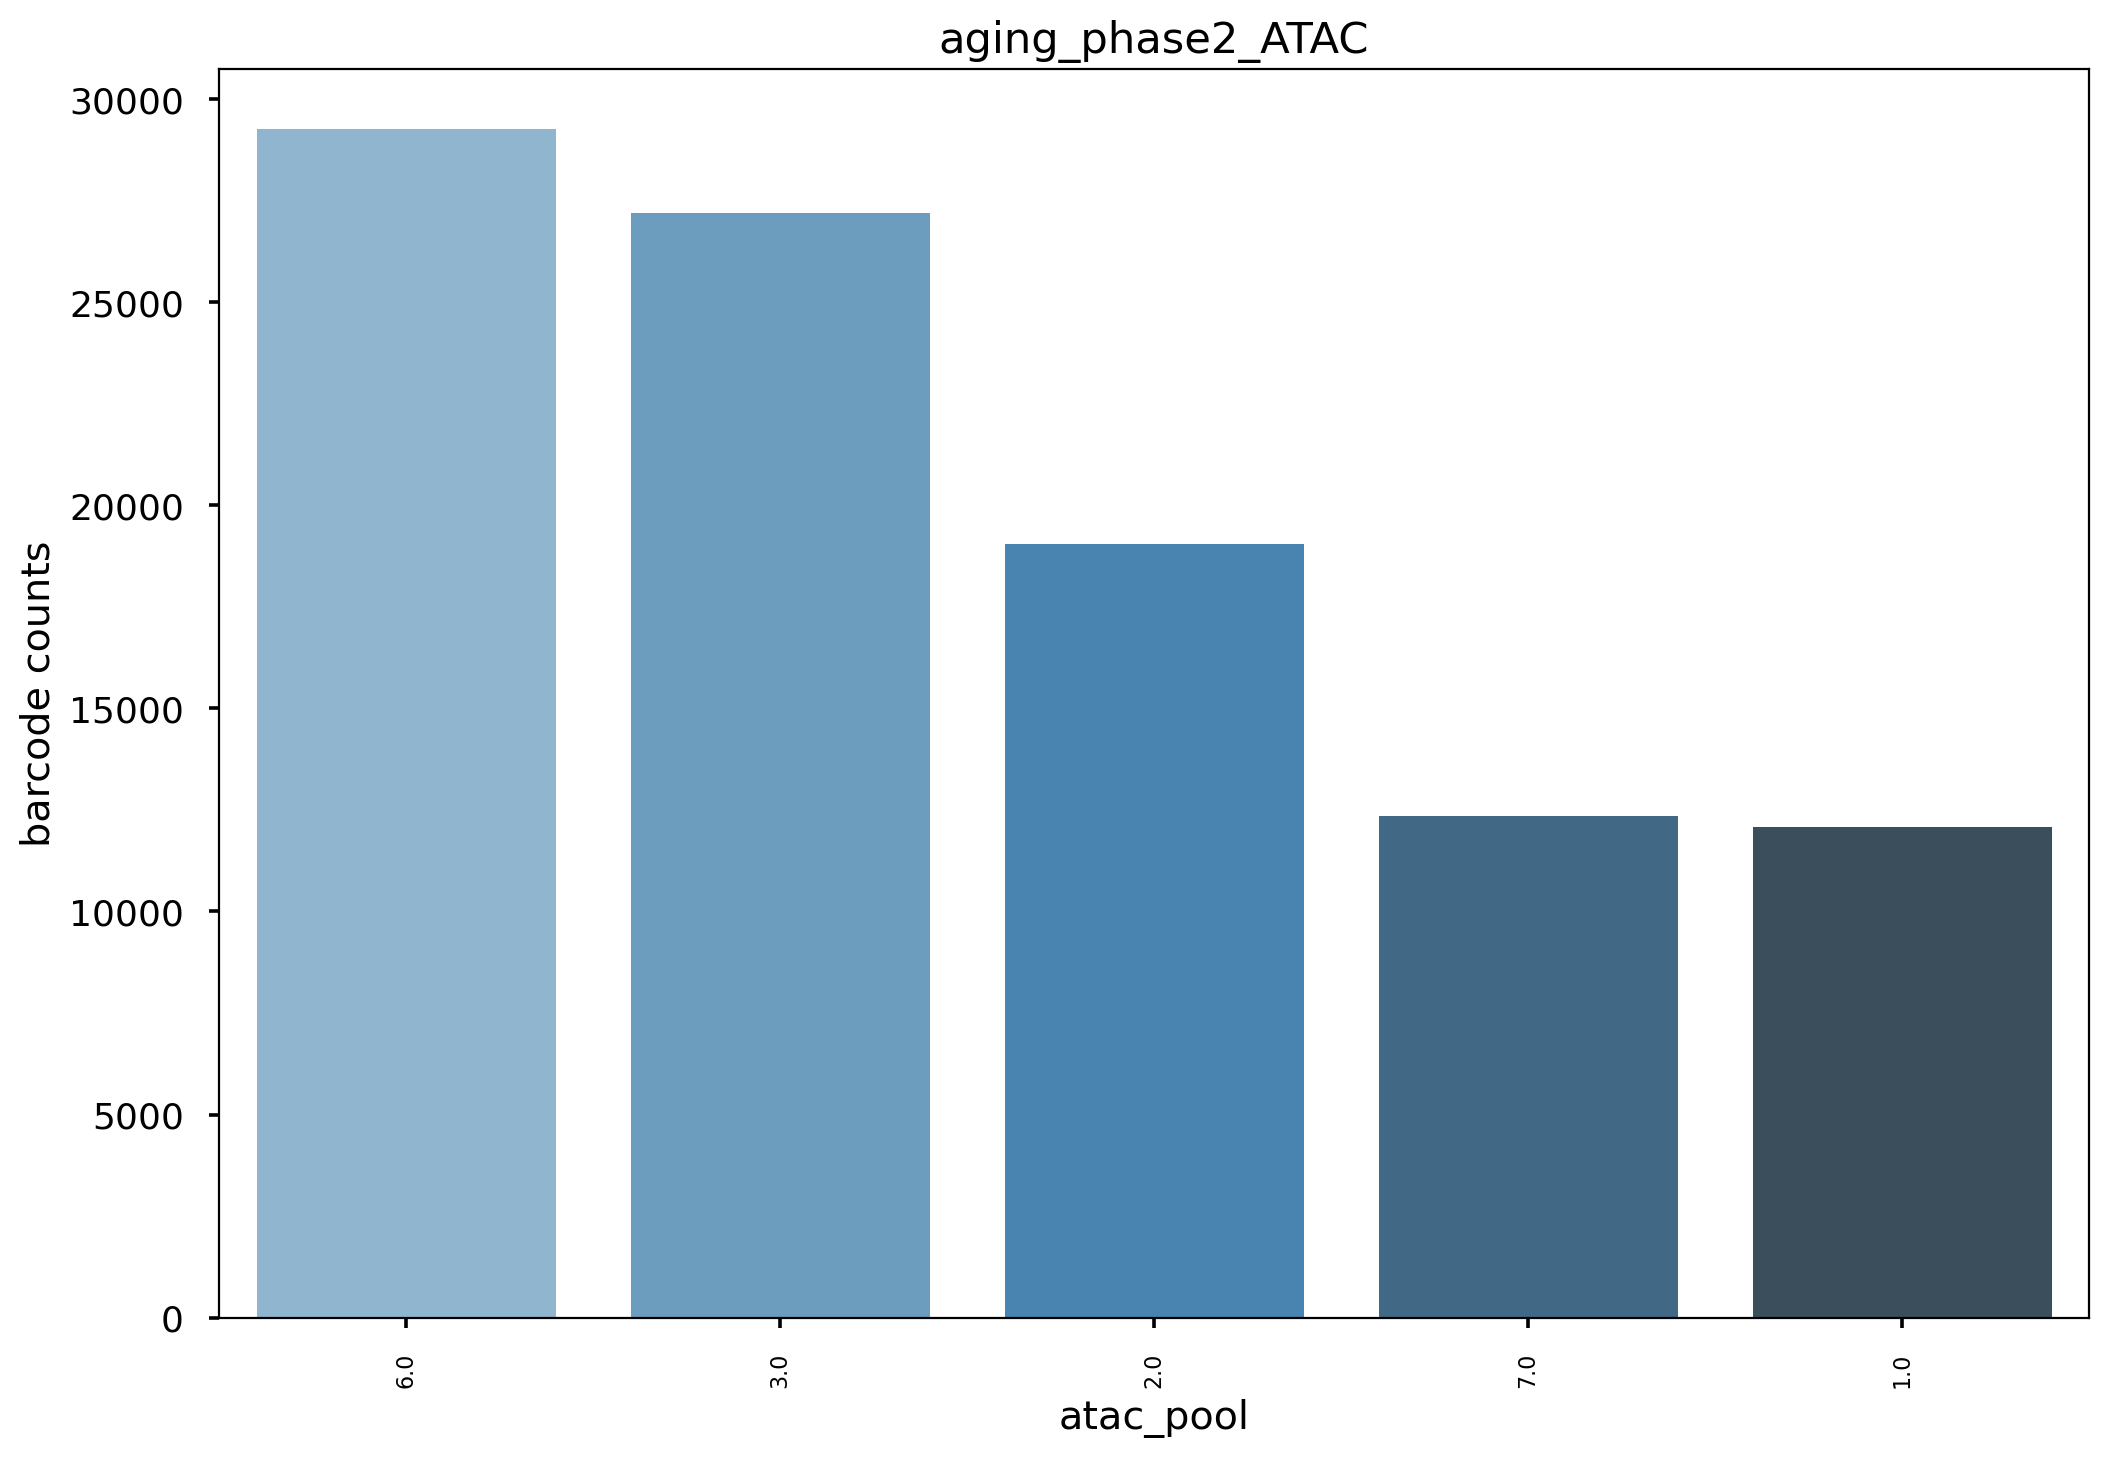

atac_pool
6.0    29274
3.0    27197
2.0    19060
7.0    12356
1.0    12090
Name: count, dtype: int64


In [26]:
plot_sample_barcode_counts(adata.obs, set_name, 'atac_pool')

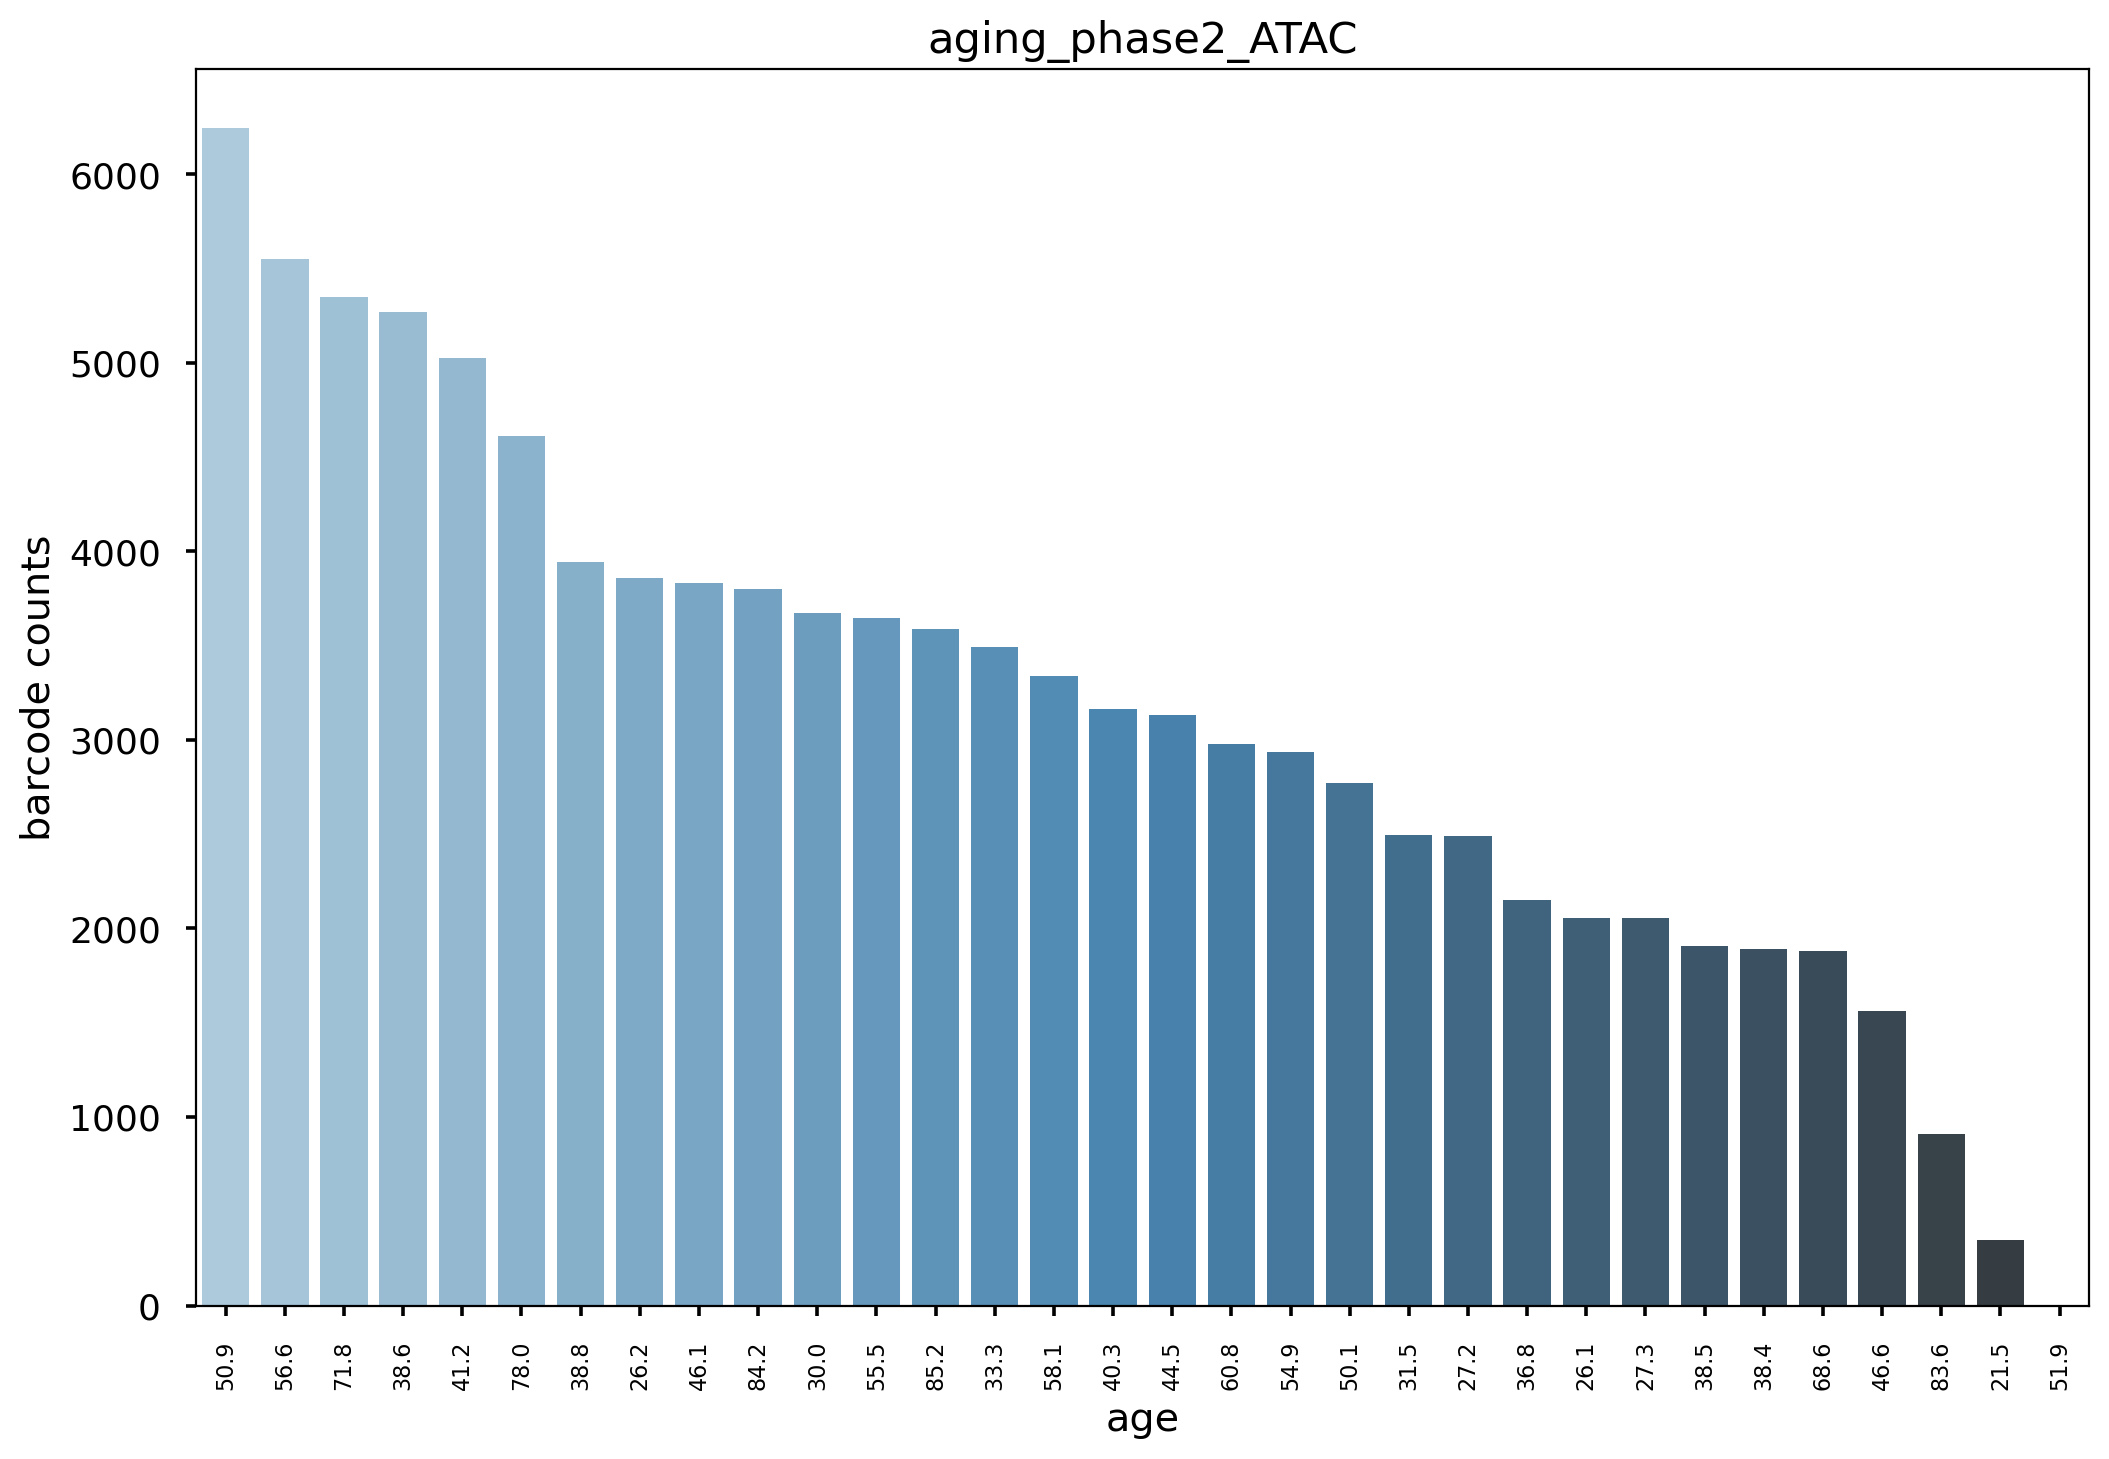

age
50.9    6245
56.6    5552
71.8    5350
38.6    5268
41.2    5025
78.0    4610
38.8    3944
26.2    3859
46.1    3833
84.2    3802
30.0    3675
55.5    3648
85.2    3591
33.3    3495
58.1    3337
40.3    3164
44.5    3135
60.8    2977
54.9    2938
50.1    2771
31.5    2497
27.2    2491
36.8    2149
26.1    2058
27.3    2056
38.5    1908
38.4    1893
68.6    1883
46.6    1562
83.6     908
21.5     350
51.9       3
Name: count, dtype: int64


In [27]:
plot_sample_barcode_counts(adata.obs, set_name, 'age')

### save the modified anndata object

In [28]:
adata.write(output_file)

In [29]:
!date

Wed Aug 30 15:04:55 EDT 2023
